# Notebook per regressione lineare

Di seguito:
- verrà implementato l'algoritmo di regressione logistica

## Scaricamento dei dati

In [1]:
# File per scaricare i dati per fare analisi di machine learning

import requests
import zipfile
import io
import os

# List of URLs to your zipped files on AWS
urls = [
    "https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_training_data.zip",
    "https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_validation_data.zip",
    "https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_test_data.zip",
]

# Directory to save the extracted files
output_dir = "dataset"
os.makedirs(output_dir, exist_ok=True)

for url in urls:
    try:
        print(f"Downloading {url}...")
        response = requests.get(url, stream=True)
        response.raise_for_status() # Raise an exception for bad status codes

        # Read the zip file from the response content
        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
            # Extract all contents to the specified output directory
            zip_ref.extractall(output_dir)
            print(f"Extracted files from {url} to {output_dir}")

    except requests.exceptions.RequestException as e:
        print(f"Error downloading {url}: {e}")
    except zipfile.BadZipFile:
        print(f"Error: The downloaded file from {url} is not a valid zip file.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

print("Download and extraction complete.")

# Now you can access your CSV files in the 'downloaded_data' directory
# For example, to list the files in the directory:
import glob
csv_files = glob.glob(os.path.join(output_dir, "*.csv"))
print("CSV files found:", csv_files)

Extracted files from https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_training_data.zip to dataset
Extracted files from https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_validation_data.zip to dataset
Extracted files from https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_test_data.zip to dataset
Download and extraction complete.
CSV files found: ['dataset/X_train.csv', 'dataset/y_data.csv', 'dataset/y_train.csv', 'dataset/X_data.csv', 'dataset/X_test.csv', 'dataset/X_validation.csv']


## Creazione variabile dati

Prendo i dati (per la challenge era relativa al solo train) dalla cartella e creo la variabile contenente tutti i dati e lo stato di salute delle turbine.

In [2]:
import pandas as pd

def load_data(x_path, y_path):
  """
  Loads X.csv and the second column of y.csv into a single pandas DataFrame.

  Args:
    x_path (str): The path to the X.csv file.
    y_path (str): The path to the y.csv file.

  Returns:
    pandas.DataFrame: A DataFrame containing the data from X.csv
                      and the second column of y.csv.
  """
  x = pd.read_csv(x_path)
  y = pd.read_csv(y_path)

  # Assuming y has at least 2 columns and the second column is at index 1
  if y.shape[1] > 1:
    combined_data = x.copy()
    combined_data['y_target'] = y.iloc[:, 1]
    return combined_data
  else:
    print("Error: y.csv does not have a second column.")
    return x

# Example usage:
# Assuming your files are in the 'dataset' directory as per the preceding code
x_path = 'dataset/X_train.csv'
y_path = 'dataset/y_train.csv'

data = load_data(x_path, y_path)

# You can now work with the 'data' DataFrame
print(data.head())


   id  trq_measured       oat       mgt         pa       ias         np  \
0   0        54.100   2.00000  544.5000   212.1408  74.56250   89.18000   
1   1        49.625  24.22231  578.4844  1625.6400  30.35596   99.55273   
2   2        52.000   7.00000  566.1000  1912.9250  65.62500  100.14000   
3   3        62.400   7.25000  560.1000   277.0632  54.81250   90.64000   
4   4        62.900  23.25000  593.7000    53.6448  73.43750   99.91000   

         ng  y_target  
0   99.6400         1  
1   91.3866         0  
2   90.9600         1  
3  100.2800         0  
4   92.1700         0  


## Creazione training set, test set

In [11]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

print("Dimensione data_train:", data_train.shape)
print("Dimensione data_test:", data_test.shape)

Dimensione data_train: (594100, 9)
Dimensione data_test: (148525, 9)


# CREANDO SOLO UNA VOLTA I K FOLDS

# Creazione K-folds

In [45]:
# prompt: dividi il dataset in k folds per la validation and make them usable for later validation. make them into data frame. create a dataframe 'x_validation' for validation and 'x_train' for train.  Create dataframe 'y_validation' and 'y_train' containing only the feature 'id' and 'y_target'

from sklearn.model_selection import KFold

# Assuming 'data_train' is the DataFrame you want to split into k folds
n_splits = 10  # You can change the number of splits (k) as needed
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store the k folds
x_train = []
x_validation = []
y_train = []
y_validation = []

for train_index, val_index in kf.split(data_train):
    # Create the training and validation sets for the current fold
    x_train1 = data_train.iloc[train_index].drop(columns=['y_target'])
    x_validation1 = data_train.iloc[val_index].drop(columns=['y_target'])

    # Create the target dataframes containing 'id' and 'y_target'
    y_train1 = data_train.iloc[train_index][['id', 'y_target']]
    y_validation1 = data_train.iloc[val_index][['id', 'y_target']]

    # Append the dataframes to the lists
    x_train.append(x_train1)
    x_validation.append(x_validation1)
    y_train.append(y_train1)
    y_validation.append(y_validation1)

# Now you have k sets of training and validation dataframes stored in the lists.
# For example, to access the first fold:
x_train_fold_1 = x_train[0]
x_validation_fold_1 = x_validation[0]
y_train_fold_1 = y_train[0]
y_validation_fold_1 = y_validation[0]

print(f"Number of created: {len(x_train)}")
print("Shape of the first fold's x_train:", x_train[0].shape)
print("Shape of the first fold's x_validation:", x_validation[0].shape)
print("Shape of the first fold's y_train:", y_train[0].shape)
print("Shape of the first fold's y_validation:", y_validation[0].shape)


Number of created: 10
Shape of the first fold's x_train: (534690, 8)
Shape of the first fold's x_validation: (59410, 8)
Shape of the first fold's y_train: (534690, 2)
Shape of the first fold's y_validation: (59410, 2)


In [32]:
# prompt: dividi il dataset in k per la validation and make them usable for later validation. make them into data frame. create a dataframe 'x_validation' for validation and 'x_train' for train.  Create dataframe 'y_validation' and 'y_train' containing only the feature 'health state'

from sklearn.model_selection import KFold

# Assuming 'data_train' is your full training DataFrame containing features and the target 'y_target'
X = data_train.drop('y_target', axis=1)
y = data_train['y_target']

# Define the number of
k_folds = 5  # You can change this number

# Initialize KFold
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Create lists to store the train and validation dataframes for each fold
x_train = []
x_validation = []
y_train = []
y_validation = []

# Iterate over the
for train_index, val_index in kf.split(X):
    # Create the training and validation feature dataframes for the current fold
    x_train_fold = X.iloc[train_index].copy()
    x_validation_fold = X.iloc[val_index].copy()

    # Create the training and validation target dataframes for the current fold
    y_train_fold = y.iloc[train_index].to_frame(name='y_target')
    y_validation_fold = y.iloc[val_index].to_frame(name='y_target')

    # Append the dataframes to the lists
    x_train.append(x_train_fold)
    x_validation.append(x_validation_fold)
    y_train.append(y_train_fold)
    y_validation.append(y_validation_fold)

# Now you have k_fol1ds sets of training and validation dataframes stored in the lists.
# For example, to access the first fold's data:
# x_train_fold_1 = x_train[0]
# x_validation_fold_1 = x_validation[0]
# y_train_fold_1 = y_train[0]
# y_validation_fold_1 = y_validation[0]

print(f"Created {k_folds} folds.")
print(f"Example of the first fold's x_train_fold:")
print(x_train[0].head())
print(f"Example of the first fold's y_train_fold:")
print(y_train[0].head())

Created 5 folds.
Example of the first fold's x_train_fold:
            id  trq_measured     oat       mgt         pa        ias  \
601458  601458       67.0332  20.152  602.4063   958.4962   96.97656   
664037  664037       53.9000   5.500  532.1000   360.8832   61.87500   
346977  346977       73.3000  17.750  636.3000  1025.9570   89.50000   
675408  675408       72.4000  15.250  646.7000   573.6336  118.50000   
74688    74688       80.0000  20.500  637.6000   496.5192  117.37500   

              np         ng  
601458  99.65235   94.02332  
664037  88.91000   99.78000  
346977  99.98000   95.95000  
675408  96.27000  100.36000  
74688   99.82000   96.56000  
Example of the first fold's y_train_fold:
        y_target
601458         0
664037         0
346977         1
675408         0
74688          0


In [46]:
x_train[0]

,id,trq_measured,oat,mgt,pa,ias,np,ng
331067,331067,74.80000,19.50000,646.1000,1005.8400,56.00000,100.19000,96.47000
601458,601458,67.03320,20.15200,602.4063,958.4962,96.97656,99.65235,94.02332
664037,664037,53.90000,5.50000,532.1000,360.8832,61.87500,88.91000,99.78000
346977,346977,73.30000,17.75000,636.3000,1025.9570,89.50000,99.98000,95.95000
675408,675408,72.40000,15.25000,646.7000,573.6336,118.50000,96.27000,100.36000
...,...,...,...,...,...,...,...,...
259178,259178,56.30000,25.00000,576.1000,130.1496,68.18750,100.06000,90.95000
365838,365838,62.60000,3.50000,588.7000,84.4296,79.31250,91.52000,100.04000
131932,131932,81.50000,2.75000,658.4000,355.3968,112.25000,96.19000,100.03000
671155,671155,59.41211,3.27083,593.2188,2215.5740,96.89453,99.88281,93.04090


In [47]:
y_train[0]

,id,y_target
331067,331067,1
601458,601458,0
664037,664037,0
346977,346977,1
675408,675408,0
...,...,...
259178,259178,0
365838,365838,1
131932,131932,1
671155,671155,1


# Pipeline

# Modificata

        torque_meas  outside_air_temp  mean_gas_temp  \
331067     0.667650          0.692057       0.698165   
601458     0.581407          0.703702       0.527553   
664037     0.435575          0.442024       0.253026   
346977     0.650994          0.660803       0.659898   
675408     0.641000          0.616154       0.700508   

        power_avail_root_2.35_transformed  \
331067                           0.711213   
601458                           0.701660   
664037                           0.544911   
346977                           0.715194   
675408                           0.611213   

        indicated_air_speed_binned_5_quantile  compressor_speed_net_power_pca  \
331067                                   0.25                        0.740485   
601458                                   0.50                        0.804099   
664037                                   0.25                        0.187016   
346977                                   0.50                       

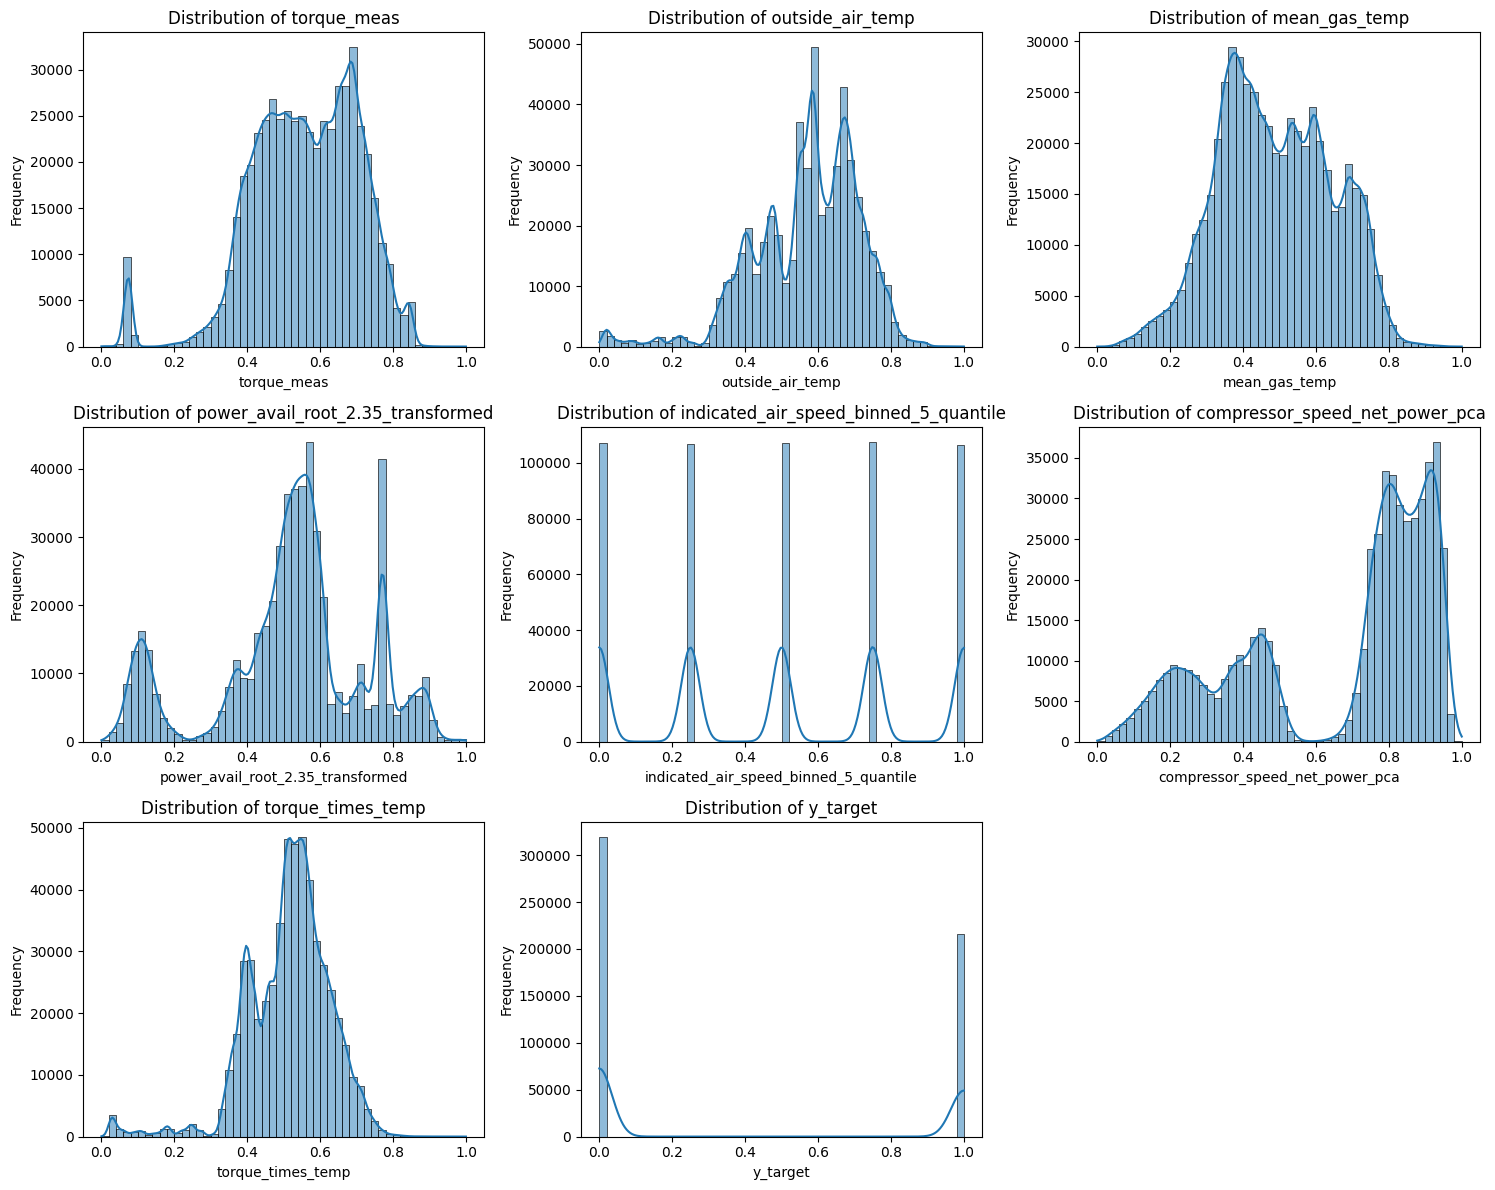

In [48]:
# Useful package
import requests
import zipfile
import io
import os

import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns



# Code for preprocessing of the dataset and for the pipeline

def load_training_data(x_train, y_train):
  """
  Loads X_train.csv and the second column of y_train.csv into a single pandas DataFrame.

  Args:
    x_path (str): The path to the X_train.csv file.
    y_path (str): The path to the y_train.csv file.

  Returns:
    pandas.DataFrame: A DataFrame containing the data from X_train.csv
                      and the second column of y_train.csv.
  """


  # Assuming y_train has at least 2 columns and the second column is at index 1
  if y_train.shape[1] > 1:
    combined_data = x_train.copy()
    combined_data['y_target'] = y_train.iloc[:, 1]
    return combined_data
  else:
    print("Error: y_train.csv does not have a second column.")
    return x_train

# x_train_path = 'dataset/X_train.csv'
# y_train_path = 'dataset/y_train.csv'

# data_train = load_training_data(x_train_path, y_train_path)



def rename_dataframe_columns(df, new_column_names):
  """
  Renames the columns of a pandas DataFrame.

  Args:
    df: The pandas DataFrame whose columns are to be renamed.
    new_column_names: A list of new column names. The length of this list
                      must match the number of columns in the DataFrame.

  Returns:
    The DataFrame with renamed columns.
  """
  if len(new_column_names) != len(df.columns):
    raise ValueError("The number of new column names must match the number of existing columns.")
  df.columns = new_column_names
  return df

# new_names_for_train_data = ['idx', 'torque_meas', 'outside_air_temp', 'mean_gas_temp', 'power_avail', 'indicated_air_speed', 'net_power', 'compressor_speed', 'health_state'] # Replace with your desired names

# data_train = rename_dataframe_columns(data_train, new_names_for_train_data)

# Aggiungere il drop della colonna di indice
# data_train = data_train.drop('idx', axis=1)


#######################################################################
#######################################################################
#######################################################################

# Da qui partono funzioni relative a trasformazioni di singole feature


def transform_with_custom_root(df, column_name, root_degree):
  """
  Applies a custom root transformation (1/root_degree power) to a column.
  Handles positive, negative, and zero values appropriately based on the root degree.

  Args:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The name of the column to transform.
    root_degree (float): The degree of the root (e.g., 2 for square root, 3 for cube root).

  Returns:
    pd.DataFrame: The DataFrame with the transformed column.
  """
  new_column_name = f'{column_name}_root_{root_degree:.2f}_transformed'

  if root_degree == 0:
      raise ValueError("Root degree cannot be zero.")
  elif root_degree % 2 == 0:  # Even root
      # For even roots, we can only take the root of non-negative numbers
      if (df[column_name] < 0).any():
          print(f"Warning: Column '{column_name}' contains negative values. Cannot apply even root directly.")
          # You might choose to handle this by taking the root of the absolute value,
          # or setting negative values to NaN, depending on your data context.
          # Here, we'll take the root of the absolute value for demonstration.
          df[new_column_name] = np.power(np.abs(df[column_name]), 1/root_degree)
      else:
          df[new_column_name] = np.power(df[column_name], 1/root_degree)
  else:  # Odd root
      # Odd roots can handle positive, negative, and zero values
      df[new_column_name] = np.sign(df[column_name]) * np.power(np.abs(df[column_name]), 1/root_degree)

  return df

# Example usage with a custom root (e.g., 1.5)
# custom_root_degree = 2.35
# data_train = transform_with_custom_root(data_train.copy(), 'power_avail', custom_root_degree)


def create_binned_qualitative_variable(df, column_name, num_bins, strategy='quantile'):
  """
  Creates a qualitative (categorical) variable by binning a numerical column.

  Args:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The name of the numerical column to bin.
    num_bins (int): The desired number of bins.
    strategy (str): The strategy to use for binning. 'quantile' uses quantiles
                    to ensure bins have approximately equal numbers of observations.
                    'uniform' creates bins with equal widths. Default is 'quantile'.

  Returns:
    pd.DataFrame: The DataFrame with a new qualitative column.
                  The new column name will be f'{column_name}_binned_{num_bins}_{strategy}'.
  """
  if column_name not in df.columns:
    raise ValueError(f"La colonna '{column_name}' non è presente nel DataFrame.")
  if num_bins <= 1:
      raise ValueError("Il numero di bins deve essere maggiore di 1.")

  new_column_name = f'{column_name}_binned_{num_bins}_{strategy}'

  if strategy == 'quantile':
    # Use qcut to create bins based on quantiles (approximately equal number of observations)
    # `duplicates='drop'` handles cases where quantile boundaries are not unique,
    # which can happen with skewed or discrete data.
    df[new_column_name] = pd.qcut(df[column_name], q=num_bins, labels=False, duplicates='drop')
  elif strategy == 'uniform':
    # Use cut to create bins of equal width
    df[new_column_name] = pd.cut(df[column_name], bins=num_bins, labels=False, include_lowest=True)
  else:
    raise ValueError(f"Strategia di binning non valida: '{strategy}'. Scegliere tra 'quantile' o 'uniform'.")

  # Convert the binned column to object/category type if needed, or keep as int for simplicity
  # Here we keep it as int representing the bin number

  return df

# Example usage for 'indicated_air_speed':
# num_bins_indicated_air_speed = 5 # Define the number of bins
# binning_strategy = 'quantile' # Or 'uniform'

#data_train = create_binned_qualitative_variable(
#    data_train.copy(),
#    'indicated_air_speed',
#    num_bins_indicated_air_speed,
#    strategy=binning_strategy
#)




## PCA per indicated_air_speed e compressor_speed
# Select the columns for PCA
# features_for_pca = data_train[['compressor_speed', 'net_power']]
# Initialize PCA with 1 component (to combine the two variables)
# pca = PCA(n_components=1)
# Fit PCA on the selected features and transform them
# data_train['compressor_speed_net_power_pca'] = pca.fit_transform(features_for_pca)



## Creazione di torque_times_temp

# data_train['torque_times_temp'] = data_train['torque_meas'] * data_train['outside_air_temp']




# Standardizzazione
def standardize_columns(df, columns_to_standardize):
  """
  Standardizes specified columns of a pandas DataFrame to have values between 0 and 1
  using MinMaxScaler.

  Args:
    df: The pandas DataFrame to standardize.
    columns_to_standardize: A list of column names to standardize.

  Returns:
    The DataFrame with the specified columns standardized.
  """
  scaler = MinMaxScaler()
  df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])
  return df

# Example usage:
# Assuming you want to standardize all numerical columns except the index and the target variable
# Identify numerical columns (excluding 'idx' and 'health_state' in this case)
# numerical_cols = data_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
# columns_to_standardize = [col for col in numerical_cols if col not in ['idx', 'health_state']]





# Creazione pipeline
def prepare_data_pipeline(x_path, y_path, new_column_names=None,
                          root_transformations=None,
                          binning_config=None,
                          standardize=True,
                          drop_index_col='idx'):
    """
    Esegue la pipeline completa di preprocessing.

    Args:
        x_path (str): path al file X_train.csv
        y_path (str): path al file y_train.csv
        new_column_names (list): lista di nuovi nomi colonne (opzionale)
        root_transformations (dict): dict {colonna: radice}
        binning_config (dict): dict {colonna: (num_bins, strategia)}
        standardize (bool): se standardizzare le colonne numeriche
        drop_index_col (str): nome della colonna da droppare (opzionale)

    Returns:
        pd.DataFrame: DataFrame preprocessato pronto per il training
    """
    df = load_training_data(x_path, y_path)

    if new_column_names:
        df = rename_dataframe_columns(df, new_column_names + ['y_target'])

    if drop_index_col in df.columns:
        df = df.drop(drop_index_col, axis=1)

    # Trasformazioni custom root
    if root_transformations:
        for col, deg in root_transformations.items():
            df = transform_with_custom_root(df, col, deg)

    # Binning
    if binning_config:
        for col, (n_bins, strategy) in binning_config.items():
            df = create_binned_qualitative_variable(df, col, n_bins, strategy)

    # PCA: esempio hardcoded ma puoi parametrizzare se vuoi
    if {'compressor_speed', 'net_power'}.issubset(df.columns):
        pca = PCA(n_components=1)
        df['compressor_speed_net_power_pca'] = pca.fit_transform(df[['compressor_speed', 'net_power']])

    # Feature engineering manuale
    if {'torque_meas', 'outside_air_temp'}.issubset(df.columns):
        df['torque_times_temp'] = df['torque_meas'] * df['outside_air_temp']

    # Rimuovi colonne non necessarie
    columns_to_drop = ['compressor_speed','net_power','indicated_air_speed','power_avail']  # Aggiungi qui altre colonne da rimuovere
    df = df.drop(columns=columns_to_drop, errors='ignore')

    # Assicurati che 'y_target' sia l'ultima colonna
    if 'y_target' in df.columns:
        cols = [col for col in df.columns if col != 'y_target'] + ['y_target']
        df = df[cols]
    else:
        print("Warning: 'y_target' column not found in DataFrame. It will not be moved to the end.")

    # Assicurati che il DataFrame non abbia colonne duplicate
    df = df.loc[:, ~df.columns.duplicated()]

    # Assicurati che il DataFrame non abbia valori NaN
    if df.isnull().values.any():
        print("Warning: DataFrame contains NaN values. They will be filled with 0.")
        df = df.fillna(0)

    # Assicurati che il DataFrame non abbia valori infiniti
    if np.isinf(df.values).any():
        print("Warning: DataFrame contains infinite values. They will be replaced with 0.")
        df.replace([np.inf, -np.inf], 0, inplace=True)

    # Standardizzazione
    if standardize:
        target = 'y_target'
        numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
        columns_to_standardize = [col for col in numerical_cols if col != target]
        df = standardize_columns(df, columns_to_standardize)

    return df




# Configurazioni opzionali
new_column_names = ['idx', 'torque_meas', 'outside_air_temp', 'mean_gas_temp',
                    'power_avail', 'indicated_air_speed', 'net_power', 'compressor_speed']

root_transform = {'power_avail': 2.35}
binning = {'indicated_air_speed': (5, 'quantile')}

data_ready = prepare_data_pipeline(
    x_train[0], y_train[0],
    new_column_names=new_column_names,
    root_transformations=root_transform,
    binning_config=binning
)

# Esempio di stampa del DataFrame preprocessato
print(data_ready.head())
print(data_ready.describe())

n_cols = 3
n_rows = (len(data_ready.columns) + n_cols - 1) // n_cols
plt.figure(figsize=(15, n_rows * 4))
for i, col in enumerate(data_ready):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(data_ready[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig("grafico.png")

# data_ready ora è pronto per essere usato in un modello

In [50]:
# prompt: per ogni fold di train trovato "x_train" applica un modello di regressione logistica per predire il corrispondente "y_train". Poi testa il modello sul validation set corrispondente. mostra accuracy, precision, sensitivity , specitivity e AUC n una tabella

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import pandas as pd

results = []

# Loop through each fold
for i in range(len(x_train)):
    print(f"Processing Fold {i+1}")

    # Get the data for the current fold
    x_train_fold = x_train[i].copy()
    y_train_fold = y_train[i].copy()
    x_validation_fold = x_validation[i].copy()
    y_validation_fold = y_validation[i].copy()

    # Apply the preprocessing pipeline to the current fold's training data
    # Need to adapt the pipeline to take DataFrames directly instead of file paths
    # Also need to apply the *same* transformations learned on the training data
    # to the validation data. This requires saving and reusing scalers, PCA, etc.

    # For simplicity and demonstration purposes, let's create a minimal
    # preprocessing function that works on DataFrames for this example.
    # In a real scenario, you'd use scikit-learn pipelines with fit_transform
    # on training and just transform on validation.

    def minimal_pipeline(X_df, y_df, is_training=True, scaler=None):
        # Combine X and y for consistent column handling
        df = X_df.copy()
        # Ensure y_df has the correct structure and name
        if isinstance(y_df, pd.Series):
             df['y_target'] = y_df.values
        elif isinstance(y_df, pd.DataFrame) and 'y_target' in y_df.columns:
             df['y_target'] = y_df['y_target'].values
        elif isinstance(y_df, pd.DataFrame) and y_df.shape[1] > 0: # Assuming the first column is the target
             df['y_target'] = y_df.iloc[:, 0].values
        else:
             raise ValueError("y_df is not in a recognized format (Series or DataFrame with 'y_target').")


        # Drop the 'id' column if present, as it's not a feature for the model
        if 'id' in df.columns:
            df = df.drop('id', axis=1)

        # Separate target again
        if 'y_target' in df.columns:
            y_processed = df['y_target']
            X_processed = df.drop('y_target', axis=1)
        else:
             y_processed = None # Or handle appropriately
             X_processed = df

        # Simple Standardization (for demonstration - ideally use a fitted scaler)
        numerical_cols = X_processed.select_dtypes(include=np.number).columns.tolist()

        if is_training:
            temp_scaler = MinMaxScaler()
            X_processed[numerical_cols] = temp_scaler.fit_transform(X_processed[numerical_cols])
            return X_processed, y_processed, temp_scaler # Return the fitted scaler
        else:
            if scaler is None:
                 raise ValueError("Scaler must be provided for validation data.")
            X_processed[numerical_cols] = scaler.transform(X_processed[numerical_cols])
            return X_processed, y_processed, None # Don't return scaler for validation

    # Apply pipeline to train data and get the fitted scaler
    x_train_processed, y_train_processed, fitted_scaler = minimal_pipeline(x_train_fold, y_train_fold, is_training=True)

    # Apply pipeline to validation data using the fitted scaler
    x_validation_processed, y_validation_processed, _ = minimal_pipeline(x_validation_fold, y_validation_fold, is_training=False, scaler=fitted_scaler)

    # Initialize and train the Logistic Regression model
    model = LogisticRegression(solver='liblinear', random_state=42) # Using liblinear for small datasets/L2 regularization
    model.fit(x_train_processed, y_train_processed)

    # Predict on the validation set
    y_pred = model.predict(x_validation_processed)
    y_prob = model.predict_proba(x_validation_processed)[:, 1] # Probability of the positive class

    # Evaluate the model
    accuracy = accuracy_score(y_validation_processed, y_pred)
    precision = precision_score(y_validation_processed, y_pred)
    sensitivity = recall_score(y_validation_processed, y_pred) # Sensitivity is the same as recall
    auc = roc_auc_score(y_validation_processed, y_prob)

    # Calculate Specificity
    cm = confusion_matrix(y_validation_processed, y_pred)
    # TN = True Negatives, FP = False Positives, FN = False Negatives, TP = True Positives
    TN, FP, FN, TP = cm.ravel()
    specificity = TN / (TN + FP)

    # Store the results for this fold
    results.append({
        'Fold': i + 1,
        'Accuracy': accuracy,
        'Precision': precision,
        'Sensitivity (Recall)': sensitivity,
        'Specificity': specificity,
        'AUC': auc
    })

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Display the results table
print("\nPerformance Metrics per Fold (Validation Set):")
print(results_df.to_string(index=False))

# Optional: Calculate and display the average performance across all folds
print("\nAverage Performance Across Folds:")
print(results_df.mean().to_frame().T.to_string(index=False))


Processing Fold 1
Processing Fold 2
Processing Fold 3
Processing Fold 4
Processing Fold 5
Processing Fold 6
Processing Fold 7
Processing Fold 8
Processing Fold 9
Processing Fold 10

Performance Metrics per Fold (Validation Set):
 Fold  Accuracy  Precision  Sensitivity (Recall)  Specificity      AUC
    1  0.923127   0.908732              0.898628     0.939540 0.973751
    2  0.921798   0.911373              0.893713     0.940897 0.973052
    3  0.920956   0.908820              0.892909     0.939802 0.973349
    4  0.921209   0.910512              0.894606     0.939510 0.973036
    5  0.921427   0.907230              0.894766     0.939157 0.972914
    6  0.921444   0.908926              0.895497     0.939065 0.972930
    7  0.921411   0.908458              0.896022     0.938659 0.972911
    8  0.920165   0.907722              0.893403     0.938335 0.972299
    9  0.919727   0.904992              0.893874     0.937066 0.972298
   10  0.920485   0.907496              0.893449     0.938686

# CREANDO OGNI VOLTA I K-FOLDS

# Premodifica

   torque_meas  outside_air_temp  mean_gas_temp  \
0     0.437796          0.379132       0.301445   
1     0.388105          0.775611       0.434144   
2     0.414477          0.468339       0.385787   
3     0.529960          0.472799       0.362358   
4     0.535512          0.758263       0.493557   

   power_avail_root_2.35_transformed  indicated_air_speed_binned_5_quantile  \
0                           0.483366                                   0.25   
1                           0.817840                                   0.00   
2                           0.859217                                   0.25   
3                           0.512556                                   0.25   
4                           0.375913                                   0.25   

   compressor_speed_net_power_pca  torque_times_temp  y_target  
0                        0.202284           0.377608         1  
1                        0.887659           0.594078         0  
2                      

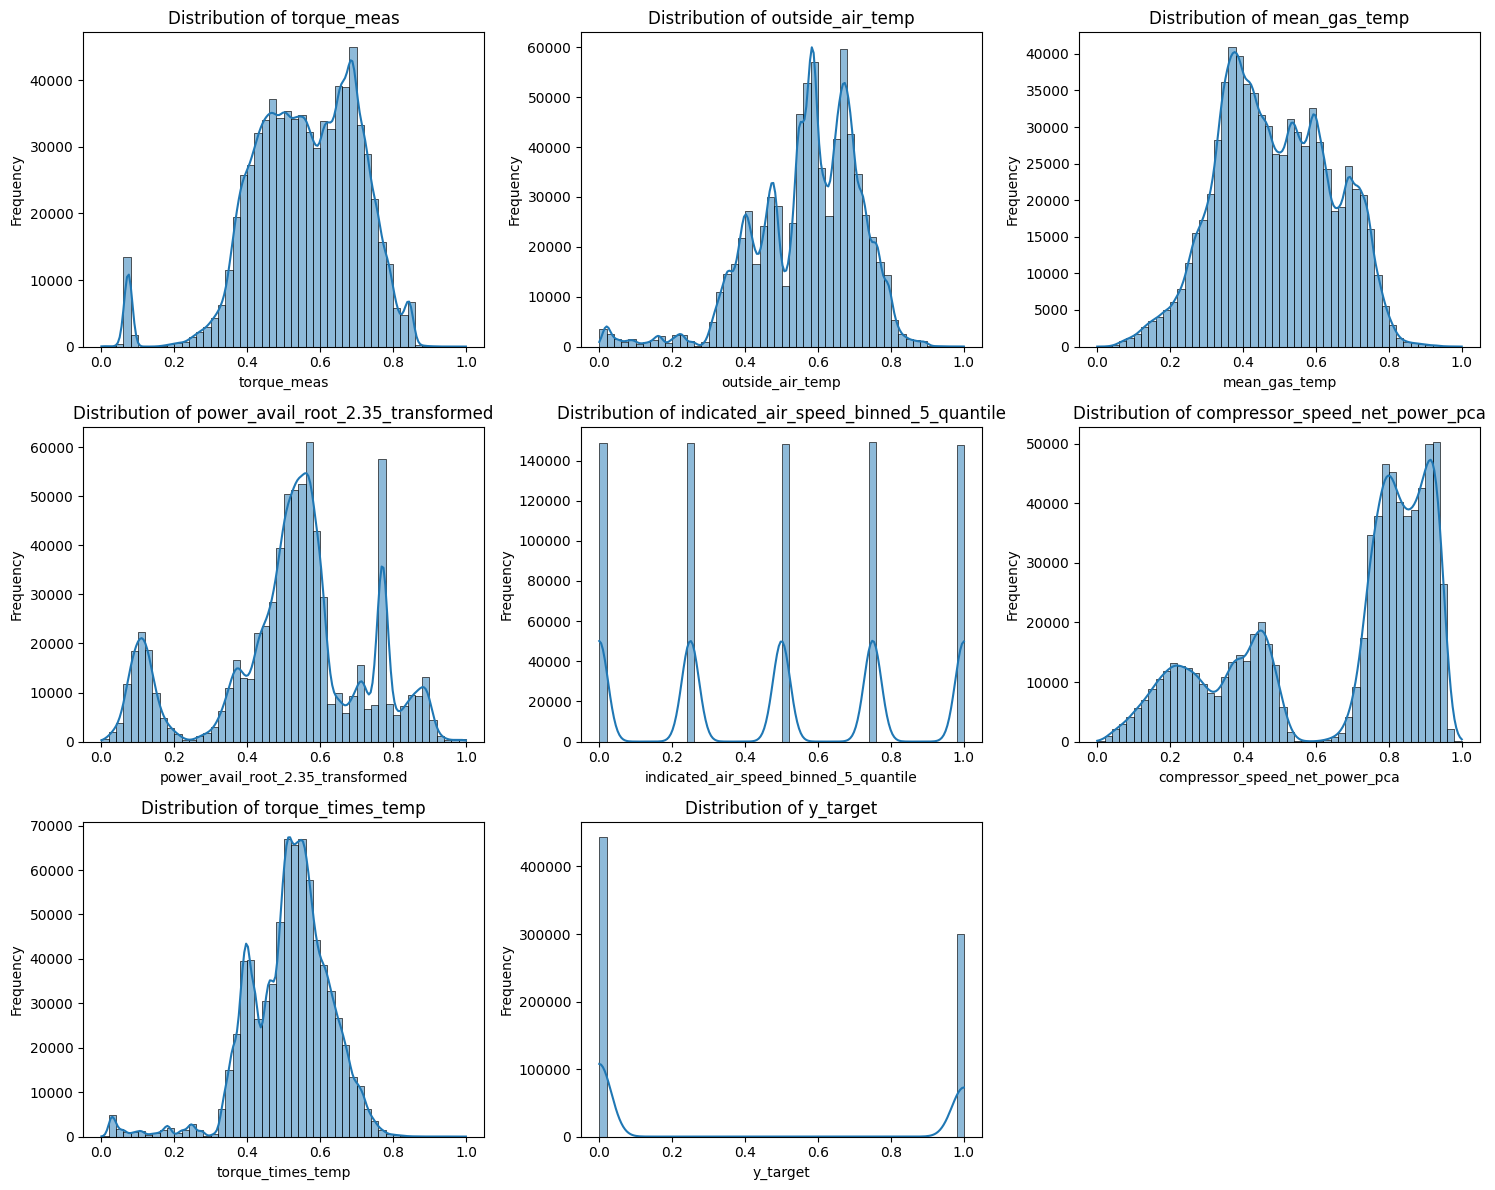

In [ ]:
# Useful package
import requests
import zipfile
import io
import os

import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns



# Code for preprocessing of the dataset and for the pipeline

def load_training_data(x_path, y_path):
  """
  Loads X_train.csv and the second column of y_train.csv into a single pandas DataFrame.

  Args:
    x_path (str): The path to the X_train.csv file.
    y_path (str): The path to the y_train.csv file.

  Returns:
    pandas.DataFrame: A DataFrame containing the data from X_train.csv
                      and the second column of y_train.csv.
  """
  x_train = pd.read_csv(x_path)
  y_train = pd.read_csv(y_path)

  # Assuming y_train has at least 2 columns and the second column is at index 1
  if y_train.shape[1] > 1:
    combined_data = x_train.copy()
    combined_data['y_target'] = y_train.iloc[:, 1]
    return combined_data
  else:
    print("Error: y_train.csv does not have a second column.")
    return x_train

# x_train_path = 'dataset/X_train.csv'
# y_train_path = 'dataset/y_train.csv'

# data_train = load_training_data(x_train_path, y_train_path)



def rename_dataframe_columns(df, new_column_names):
  """
  Renames the columns of a pandas DataFrame.

  Args:
    df: The pandas DataFrame whose columns are to be renamed.
    new_column_names: A list of new column names. The length of this list
                      must match the number of columns in the DataFrame.

  Returns:
    The DataFrame with renamed columns.
  """
  if len(new_column_names) != len(df.columns):
    raise ValueError("The number of new column names must match the number of existing columns.")
  df.columns = new_column_names
  return df

# new_names_for_train_data = ['idx', 'torque_meas', 'outside_air_temp', 'mean_gas_temp', 'power_avail', 'indicated_air_speed', 'net_power', 'compressor_speed', 'health_state'] # Replace with your desired names

# data_train = rename_dataframe_columns(data_train, new_names_for_train_data)

# Aggiungere il drop della colonna di indice
# data_train = data_train.drop('idx', axis=1)


#######################################################################
#######################################################################
#######################################################################

# Da qui partono funzioni relative a trasformazioni di singole feature


def transform_with_custom_root(df, column_name, root_degree):
  """
  Applies a custom root transformation (1/root_degree power) to a column.
  Handles positive, negative, and zero values appropriately based on the root degree.

  Args:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The name of the column to transform.
    root_degree (float): The degree of the root (e.g., 2 for square root, 3 for cube root).

  Returns:
    pd.DataFrame: The DataFrame with the transformed column.
  """
  new_column_name = f'{column_name}_root_{root_degree:.2f}_transformed'

  if root_degree == 0:
      raise ValueError("Root degree cannot be zero.")
  elif root_degree % 2 == 0:  # Even root
      # For even roots, we can only take the root of non-negative numbers
      if (df[column_name] < 0).any():
          print(f"Warning: Column '{column_name}' contains negative values. Cannot apply even root directly.")
          # You might choose to handle this by taking the root of the absolute value,
          # or setting negative values to NaN, depending on your data context.
          # Here, we'll take the root of the absolute value for demonstration.
          df[new_column_name] = np.power(np.abs(df[column_name]), 1/root_degree)
      else:
          df[new_column_name] = np.power(df[column_name], 1/root_degree)
  else:  # Odd root
      # Odd roots can handle positive, negative, and zero values
      df[new_column_name] = np.sign(df[column_name]) * np.power(np.abs(df[column_name]), 1/root_degree)

  return df

# Example usage with a custom root (e.g., 1.5)
# custom_root_degree = 2.35
# data_train = transform_with_custom_root(data_train.copy(), 'power_avail', custom_root_degree)


def create_binned_qualitative_variable(df, column_name, num_bins, strategy='quantile'):
  """
  Creates a qualitative (categorical) variable by binning a numerical column.

  Args:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The name of the numerical column to bin.
    num_bins (int): The desired number of bins.
    strategy (str): The strategy to use for binning. 'quantile' uses quantiles
                    to ensure bins have approximately equal numbers of observations.
                    'uniform' creates bins with equal widths. Default is 'quantile'.

  Returns:
    pd.DataFrame: The DataFrame with a new qualitative column.
                  The new column name will be f'{column_name}_binned_{num_bins}_{strategy}'.
  """
  if column_name not in df.columns:
    raise ValueError(f"La colonna '{column_name}' non è presente nel DataFrame.")
  if num_bins <= 1:
      raise ValueError("Il numero di bins deve essere maggiore di 1.")

  new_column_name = f'{column_name}_binned_{num_bins}_{strategy}'

  if strategy == 'quantile':
    # Use qcut to create bins based on quantiles (approximately equal number of observations)
    # `duplicates='drop'` handles cases where quantile boundaries are not unique,
    # which can happen with skewed or discrete data.
    df[new_column_name] = pd.qcut(df[column_name], q=num_bins, labels=False, duplicates='drop')
  elif strategy == 'uniform':
    # Use cut to create bins of equal width
    df[new_column_name] = pd.cut(df[column_name], bins=num_bins, labels=False, include_lowest=True)
  else:
    raise ValueError(f"Strategia di binning non valida: '{strategy}'. Scegliere tra 'quantile' o 'uniform'.")

  # Convert the binned column to object/category type if needed, or keep as int for simplicity
  # Here we keep it as int representing the bin number

  return df

# Example usage for 'indicated_air_speed':
# num_bins_indicated_air_speed = 5 # Define the number of bins
# binning_strategy = 'quantile' # Or 'uniform'

#data_train = create_binned_qualitative_variable(
#    data_train.copy(),
#    'indicated_air_speed',
#    num_bins_indicated_air_speed,
#    strategy=binning_strategy
#)




## PCA per indicated_air_speed e compressor_speed
# Select the columns for PCA
# features_for_pca = data_train[['compressor_speed', 'net_power']]
# Initialize PCA with 1 component (to combine the two variables)
# pca = PCA(n_components=1)
# Fit PCA on the selected features and transform them
# data_train['compressor_speed_net_power_pca'] = pca.fit_transform(features_for_pca)



## Creazione di torque_times_temp

# data_train['torque_times_temp'] = data_train['torque_meas'] * data_train['outside_air_temp']




# Standardizzazione
def standardize_columns(df, columns_to_standardize):
  """
  Standardizes specified columns of a pandas DataFrame to have values between 0 and 1
  using MinMaxScaler.

  Args:
    df: The pandas DataFrame to standardize.
    columns_to_standardize: A list of column names to standardize.

  Returns:
    The DataFrame with the specified columns standardized.
  """
  scaler = MinMaxScaler()
  df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])
  return df

# Example usage:
# Assuming you want to standardize all numerical columns except the index and the target variable
# Identify numerical columns (excluding 'idx' and 'health_state' in this case)
# numerical_cols = data_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
# columns_to_standardize = [col for col in numerical_cols if col not in ['idx', 'health_state']]





# Creazione pipeline
def prepare_data_pipeline(x_path, y_path, new_column_names=None,
                          root_transformations=None,
                          binning_config=None,
                          standardize=True,
                          drop_index_col='idx'):
    """
    Esegue la pipeline completa di preprocessing.

    Args:
        x_path (str): path al file X_train.csv
        y_path (str): path al file y_train.csv
        new_column_names (list): lista di nuovi nomi colonne (opzionale)
        root_transformations (dict): dict {colonna: radice}
        binning_config (dict): dict {colonna: (num_bins, strategia)}
        standardize (bool): se standardizzare le colonne numeriche
        drop_index_col (str): nome della colonna da droppare (opzionale)

    Returns:
        pd.DataFrame: DataFrame preprocessato pronto per il training
    """
    df = load_training_data(x_path, y_path)

    if new_column_names:
        df = rename_dataframe_columns(df, new_column_names + ['y_target'])

    if drop_index_col in df.columns:
        df = df.drop(drop_index_col, axis=1)

    # Trasformazioni custom root
    if root_transformations:
        for col, deg in root_transformations.items():
            df = transform_with_custom_root(df, col, deg)

    # Binning
    if binning_config:
        for col, (n_bins, strategy) in binning_config.items():
            df = create_binned_qualitative_variable(df, col, n_bins, strategy)

    # PCA: esempio hardcoded ma puoi parametrizzare se vuoi
    if {'compressor_speed', 'net_power'}.issubset(df.columns):
        pca = PCA(n_components=1)
        df['compressor_speed_net_power_pca'] = pca.fit_transform(df[['compressor_speed', 'net_power']])

    # Feature engineering manuale
    if {'torque_meas', 'outside_air_temp'}.issubset(df.columns):
        df['torque_times_temp'] = df['torque_meas'] * df['outside_air_temp']

    # Rimuovi colonne non necessarie
    columns_to_drop = ['compressor_speed','net_power','indicated_air_speed','power_avail']  # Aggiungi qui altre colonne da rimuovere
    df = df.drop(columns=columns_to_drop, errors='ignore')

    # Assicurati che 'y_target' sia l'ultima colonna
    if 'y_target' in df.columns:
        cols = [col for col in df.columns if col != 'y_target'] + ['y_target']
        df = df[cols]
    else:
        print("Warning: 'y_target' column not found in DataFrame. It will not be moved to the end.")

    # Assicurati che il DataFrame non abbia colonne duplicate
    df = df.loc[:, ~df.columns.duplicated()]

    # Assicurati che il DataFrame non abbia valori NaN
    if df.isnull().values.any():
        print("Warning: DataFrame contains NaN values. They will be filled with 0.")
        df = df.fillna(0)

    # Assicurati che il DataFrame non abbia valori infiniti
    if np.isinf(df.values).any():
        print("Warning: DataFrame contains infinite values. They will be replaced with 0.")
        df.replace([np.inf, -np.inf], 0, inplace=True)

    # Standardizzazione
    if standardize:
        target = 'y_target'
        numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
        columns_to_standardize = [col for col in numerical_cols if col != target]
        df = standardize_columns(df, columns_to_standardize)

    return df



### Esempio di utilizzo della pipeline
x_path = 'dataset/X_data.csv'
y_path = 'dataset/y_data.csv'

# Configurazioni opzionali
new_column_names = ['idx', 'torque_meas', 'outside_air_temp', 'mean_gas_temp',
                    'power_avail', 'indicated_air_speed', 'net_power', 'compressor_speed']

root_transform = {'power_avail': 2.35}
binning = {'indicated_air_speed': (5, 'quantile')}

data_ready = prepare_data_pipeline(
    x_path, y_path,
    new_column_names=new_column_names,
    root_transformations=root_transform,
    binning_config=binning
)

# Esempio di stampa del DataFrame preprocessato
print(data_ready.head())
print(data_ready.describe())

n_cols = 3
n_rows = (len(data_ready.columns) + n_cols - 1) // n_cols
plt.figure(figsize=(15, n_rows * 4))
for i, col in enumerate(data_ready):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(data_ready[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig("grafico.png")

# data_ready ora è pronto per essere usato in un modello

# Regressione logistica

Starting 10-fold cross-validation...
--- Fold 1/10 ---
  Accuracy: 0.9267
  Precision: 0.9158
  Sensitivity: 0.9028
  Specificity: 0.9432
--- Fold 2/10 ---
  Accuracy: 0.9255
  Precision: 0.9131
  Sensitivity: 0.8991
  Specificity: 0.9430
--- Fold 3/10 ---
  Accuracy: 0.9251
  Precision: 0.9141
  Sensitivity: 0.9002
  Specificity: 0.9422
--- Fold 4/10 ---
  Accuracy: 0.9253
  Precision: 0.9105
  Sensitivity: 0.9023
  Specificity: 0.9407
--- Fold 5/10 ---
  Accuracy: 0.9262
  Precision: 0.9147
  Sensitivity: 0.9003
  Specificity: 0.9436
--- Fold 6/10 ---
  Accuracy: 0.9272
  Precision: 0.9159
  Sensitivity: 0.9037
  Specificity: 0.9433
--- Fold 7/10 ---
  Accuracy: 0.9254
  Precision: 0.9109
  Sensitivity: 0.9031
  Specificity: 0.9405
--- Fold 8/10 ---
  Accuracy: 0.9259
  Precision: 0.9159
  Sensitivity: 0.8995
  Specificity: 0.9438
--- Fold 9/10 ---
  Accuracy: 0.9255
  Precision: 0.9128
  Sensitivity: 0.8999
  Specificity: 0.9426
--- Fold 10/10 ---
  Accuracy: 0.9278
  Precision: 0.9

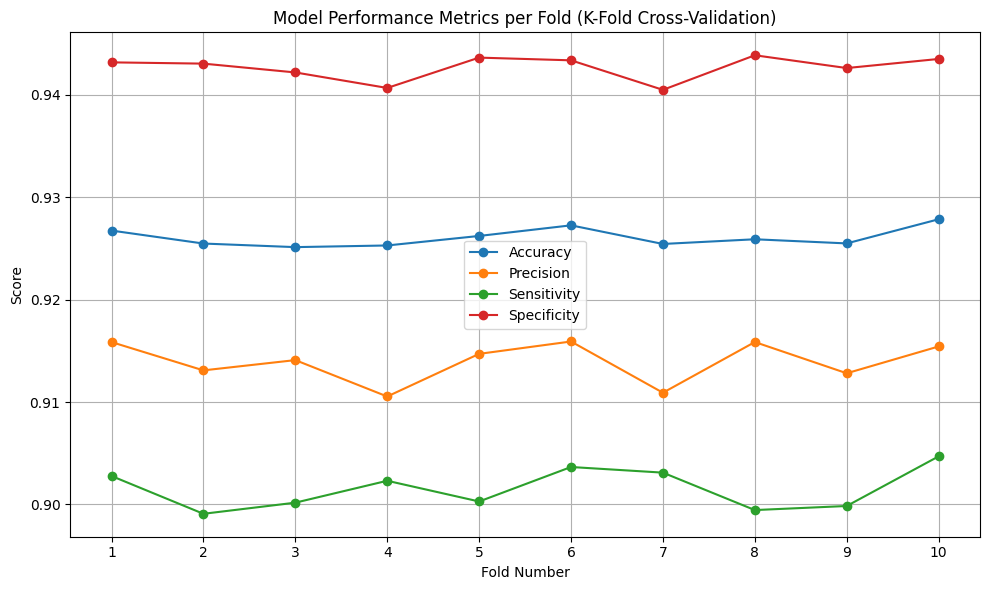

In [ ]:
# prompt: utilizza una regressione logistica per predire la feature 'health_state' sulla base delle altre feature, dopo aver elaborato le feature tramite pipeline. utilizza k-fold validation. Plotta in una tabella precision, accuracy, sensitivity e specificity

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import pandas as pd
import numpy as np

# Separate features (X) and target (y)
X = data_ready.drop('y_target', axis=1)
y = data_ready['y_target']

# Define the number of folds for K-Fold Cross-Validation
n_splits = 10  # You can adjust this number
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store metrics for each fold
accuracy_scores = []
precision_scores = []
sensitivity_scores = [] # Sensitivity is the same as Recall
specificity_scores = []

# Initialize the Logistic Regression model
# You can tune the hyperparameters here, e.g., C, solver, etc.
model = LogisticRegression(random_state=42, max_iter=1000) # Increased max_iter for convergence

print(f"Starting {n_splits}-fold cross-validation...")

# Iterate over each fold
for fold, (train_index, validation_index) in enumerate(kf.split(X)):
    print(f"--- Fold {fold+1}/{n_splits} ---")

    # Split data into training and testing sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[validation_index]
    y_train, y_test = y.iloc[train_index], y.iloc[validation_index]

    # Train the model on the training data for this fold
    model.fit(X_train, y_train)

    # Make predictions on the test data for this fold
    y_pred = model.predict(X_test)

    # Calculate metrics for this fold
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel() # True Negatives, False Positives, False Negatives, True Positives

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0) # zero_division=0 handles cases with no positive predictions
    sensitivity = recall_score(y_test, y_pred, zero_division=0)
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0 # Avoid division by zero

    # Store the metrics
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    sensitivity_scores.append(sensitivity)
    specificity_scores.append(specificity)

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Sensitivity: {sensitivity:.4f}")
    print(f"  Specificity: {specificity:.4f}")


# Calculate the average metrics across all folds
avg_accuracy = np.mean(accuracy_scores)
avg_precision = np.mean(precision_scores)
avg_sensitivity = np.mean(sensitivity_scores)
avg_specificity = np.mean(specificity_scores)

# Create a table to display the results
results = {
    'Metric': ['Accuracy', 'Precision', 'Sensitivity', 'Specificity'],
    'Average Score': [avg_accuracy, avg_precision, avg_sensitivity, avg_specificity]
}

# Add individual fold scores to the table for detailed view
for i in range(n_splits):
    results[f'Fold {i+1}'] = [accuracy_scores[i], precision_scores[i], sensitivity_scores[i], specificity_scores[i]]

results_df = pd.DataFrame(results)

print("\n--- Cross-Validation Results Table ---")
print(results_df.to_markdown(index=False, floatfmt=".4f")) # Use to_markdown for better display in Colab/Jupyter

# Optional: Plotting the metrics per fold
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_splits + 1), accuracy_scores, marker='o', linestyle='-', label='Accuracy')
plt.plot(range(1, n_splits + 1), precision_scores, marker='o', linestyle='-', label='Precision')
plt.plot(range(1, n_splits + 1), sensitivity_scores, marker='o', linestyle='-', label='Sensitivity')
plt.plot(range(1, n_splits + 1), specificity_scores, marker='o', linestyle='-', label='Specificity')
plt.title('Model Performance Metrics per Fold (K-Fold Cross-Validation)')
plt.xlabel('Fold Number')
plt.ylabel('Score')
plt.xticks(range(1, n_splits + 1))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Regressione coefficienti e indici


Starting K-Fold Cross-Validation to collect coefficients...
--- Fold 1/10 ---
  Accuracy: 0.9267
--- Fold 2/10 ---
  Accuracy: 0.9255
--- Fold 3/10 ---
  Accuracy: 0.9251
--- Fold 4/10 ---
  Accuracy: 0.9253
--- Fold 5/10 ---
  Accuracy: 0.9262
--- Fold 6/10 ---
  Accuracy: 0.9272
--- Fold 7/10 ---
  Accuracy: 0.9254
--- Fold 8/10 ---
  Accuracy: 0.9259
--- Fold 9/10 ---
  Accuracy: 0.9255
--- Fold 10/10 ---
  Accuracy: 0.9278

--- Logistic Regression Coefficients per Fold ---
|         |   torque_meas |   outside_air_temp |   mean_gas_temp |   power_avail_root_2.35_transformed |   indicated_air_speed_binned_5_quantile |   compressor_speed_net_power_pca |   torque_times_temp |   Intercept |
|:--------|--------------:|-------------------:|----------------:|------------------------------------:|----------------------------------------:|---------------------------------:|--------------------:|------------:|
| Fold 1  |      -60.0673 |           -65.8824 |         45.1033 |               

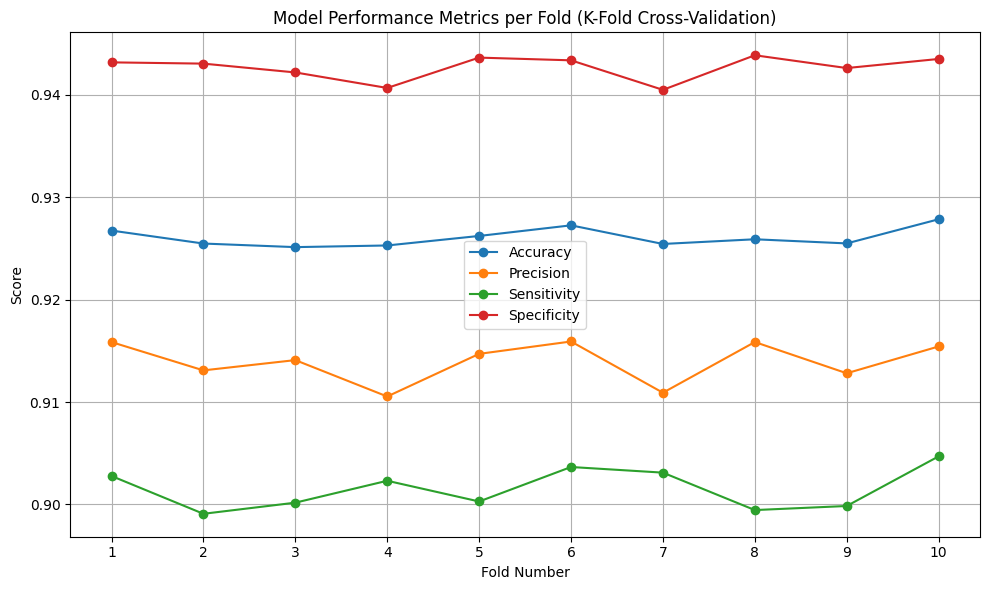

In [ ]:
# prompt: utilizza una regressione logistica per predire la feature 'health_state' sulla base delle altre feature, dopo aver elaborato le feature tramite pipeline. utilizza k-fold validation. Plotta in una tabella precision, accuracy, sensitivity e specificity e in una tabella i coefficienti per ogni fold

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Get the coefficients for each fold
coefficient_list = []

# Iterate over each fold again to get coefficients (model is already trained in the loop above)
# Note: This assumes the last trained model (from the last fold) is available.
# If you need coefficients for *each* specific fold's trained model, you need to store
# the model instance in the loop or refit it here.
# A better approach is to get coefficients *within* the fold loop. Let's modify the previous loop.

# Redo the K-Fold loop to capture coefficients per fold
coefficient_data = {}
print("\nStarting K-Fold Cross-Validation to collect coefficients...")

# Lists to store metrics for each fold (re-initialized for clarity)
accuracy_scores = []
precision_scores = []
sensitivity_scores = [] # Sensitivity is the same as Recall
specificity_scores = []

for fold, (train_index, validation_index) in enumerate(kf.split(X)):
    print(f"--- Fold {fold+1}/{n_splits} ---")

    # Split data
    X_train, X_test = X.iloc[train_index], X.iloc[validation_index]
    y_train, y_test = y.iloc[train_index], y.iloc[validation_index]

    # Initialize and train the model for this fold
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    sensitivity = recall_score(y_test, y_pred, zero_division=0)
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

    # Store the metrics
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    sensitivity_scores.append(sensitivity)
    specificity_scores.append(specificity)


    # Store coefficients for this fold
    # Logistic Regression coefficients are in model.coef_[0] for binary classification
    # model.intercept_[0] is the intercept
    fold_coefficients = {feature: coef for feature, coef in zip(X_train.columns, model.coef_[0])}
    fold_coefficients['Intercept'] = model.intercept_[0]
    coefficient_data[f'Fold {fold+1}'] = fold_coefficients

    print(f"  Accuracy: {accuracy:.4f}")


# Convert the coefficient data into a DataFrame
coefficients_df = pd.DataFrame(coefficient_data)

# Transpose the DataFrame so features are rows and folds are columns
coefficients_df = coefficients_df.T

print("\n--- Logistic Regression Coefficients per Fold ---")
print(coefficients_df.to_markdown(floatfmt=".4f"))

# Calculate the average metrics across all folds again (as we re-calculated them)
avg_accuracy = np.mean(accuracy_scores)
avg_precision = np.mean(precision_scores)
avg_sensitivity = np.mean(sensitivity_scores)
avg_specificity = np.mean(specificity_scores)

# Create a table to display the results (re-creating as we re-calculated)
results = {
    'Metric': ['Accuracy', 'Precision', 'Sensitivity', 'Specificity'],
    'Average Score': [avg_accuracy, avg_precision, avg_sensitivity, avg_specificity]
}

# Add individual fold scores to the table for detailed view
for i in range(n_splits):
    results[f'Fold {i+1}'] = [accuracy_scores[i], precision_scores[i], sensitivity_scores[i], specificity_scores[i]]

results_df = pd.DataFrame(results)

print("\n--- Cross-Validation Results Table (Recalculated) ---")
print(results_df.to_markdown(index=False, floatfmt=".4f"))


# Optional: Plotting the metrics per fold (re-plotting as we re-calculated)
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_splits + 1), accuracy_scores, marker='o', linestyle='-', label='Accuracy')
plt.plot(range(1, n_splits + 1), precision_scores, marker='o', linestyle='-', label='Precision')
plt.plot(range(1, n_splits + 1), sensitivity_scores, marker='o', linestyle='-', label='Sensitivity')
plt.plot(range(1, n_splits + 1), specificity_scores, marker='o', linestyle='-', label='Specificity')
plt.title('Model Performance Metrics per Fold (K-Fold Cross-Validation)')
plt.xlabel('Fold Number')
plt.ylabel('Score')
plt.xticks(range(1, n_splits + 1))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
